In [1]:
from modules.utils import load_datasets_statforecast_uni
data_path = '/Users/moji/PyTSF-MfG/data'
datasets = load_datasets_statforecast_uni(data_path)


Loading dataset: air_passengers
File path: /Users/moji/PyTSF-MfG/data/AirPassengers.csv
Date parsing complete for air_passengers
Dataset shape for air_passengers: (144, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  144 non-null    object        
 1   ds         144 non-null    datetime64[ns]
 2   y          144 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 3.5+ KB
None
    unique_id         ds    y
0  Passengers 1949-01-01  112
1  Passengers 1949-02-01  118
2  Passengers 1949-03-01  132
3  Passengers 1949-04-01  129
4  Passengers 1949-05-01  121
Most common time difference: 31 days 00:00:00

Loading dataset: ETTh1
File path: /Users/moji/PyTSF-MfG/data/ETTh1.csv
Date parsing complete for ETTh1
Dataset shape for ETTh1: (17420, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex

In [2]:
df = datasets['ISO-NY']
print(df)

      unique_id                  ds          y
0          Load 2023-01-01 00:00:00  1452.1995
1          Load 2023-01-01 00:15:00  1446.8088
2          Load 2023-01-01 00:30:00  1393.8522
3          Load 2023-01-01 00:45:00  1434.0576
4          Load 2023-01-01 01:00:00  1416.6898
...         ...                 ...        ...
58319      Load 2024-08-30 11:45:00  1842.7579
58320      Load 2024-08-30 12:00:00  1824.3923
58321      Load 2024-08-30 12:15:00  1840.4033
58322      Load 2024-08-30 12:30:00  1791.7378
58323      Load 2024-08-30 12:45:00  1790.8900

[58324 rows x 3 columns]


In [3]:
from darts import TimeSeries
import numpy as np

# Assuming your data is in a DataFrame called 'df'
series = TimeSeries.from_dataframe(df, 'ds', 'y', freq='15min')

# Check for missing values
has_missing = np.isnan(series.values()).any()
print("Has missing values:", has_missing)

Has missing values: False


In [4]:
train, test = series.split_before(0.9)
test

<TimeSeries (DataArray) (ds: 5834, component: 1, sample: 1)> Size: 47kB
array([[[1699.6738]],

       [[1732.5017]],

       [[1775.9005]],

       ...,

       [[1840.4033]],

       [[1791.7378]],

       [[1790.89  ]]])
Coordinates:
  * ds         (ds) datetime64[ns] 47kB 2024-06-30T18:30:00 ... 2024-08-30T12...
  * component  (component) object 8B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [5]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
test_scaled

<TimeSeries (DataArray) (ds: 5834, component: 1, sample: 1)> Size: 47kB
array([[[0.38281346]],

       [[0.40147658]],

       [[0.4261494 ]],

       ...,

       [[0.46282015]],

       [[0.43515313]],

       [[0.43467115]]])
Coordinates:
  * ds         (ds) datetime64[ns] 47kB 2024-06-30T18:30:00 ... 2024-08-30T12...
  * component  (component) object 8B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='ds'>

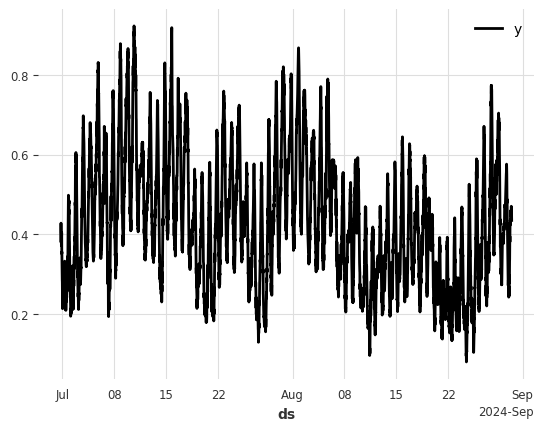

In [6]:
test_scaled.plot()

In [7]:
from modules.algorithm_factory import create_algorithm

algorithm_name = 'TCN'
model = create_algorithm(algorithm_name, runtime_params= {"input_chunk_length": 50, "output_chunk_length": 12})
model

Base configuration for TCN: {'name': 'TCN', 'class': 'darts.models.TCNModel', 'default_params': {'num_layers': 1, 'num_filters': 64, 'dilation_base': 1, 'kernel_size': 6, 'n_epochs': 20, 'force_reset': 'True', 'pl_trainer_kwargs': {'accelerator': 'cpu'}}, 'data_format': 'Darts'}
Final parameters for TCN: {'num_layers': 1, 'num_filters': 64, 'dilation_base': 1, 'kernel_size': 6, 'n_epochs': 20, 'force_reset': 'True', 'pl_trainer_kwargs': {'accelerator': 'cpu'}, 'input_chunk_length': 50, 'output_chunk_length': 12}


TCNModel(output_chunk_shift=0, kernel_size=6, num_filters=64, num_layers=1, dilation_base=1, weight_norm=False, dropout=0.2, n_epochs=20, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu'}, input_chunk_length=50, output_chunk_length=12)

In [8]:
model.fit(train_scaled)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/moji/PyTSF-MfG/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 833    | train
-------------------------------------------------------------
833       Trainable params
0         Non-trainable params
833       Total params
0.003     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


TCNModel(output_chunk_shift=0, kernel_size=6, num_filters=64, num_layers=1, dilation_base=1, weight_norm=False, dropout=0.2, n_epochs=20, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu'}, input_chunk_length=50, output_chunk_length=12)

In [ ]:
import warnings
import logging

warnings.filterwarnings("ignore")
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

In [ ]:
forecasting_horizon = 3
predictions = model.predict(forecasting_horizon)

In [ ]:
# Make predictions
prediction_length = len(test_scaled)
predictions = []
history = train_scaled  # Start with the training data as history

for i in range(0, prediction_length, model.output_chunk_length):
    n = min(model.output_chunk_length, prediction_length - i)
    pred = model.predict(n=n, series=history, verbose=False)
    predictions.append(pred)
    
    # Update history with the true values
    history = history.append(test_scaled[i:i+n])

In [ ]:
len(predictions)

In [ ]:
combined_predictions = predictions[0]
for pred in predictions[1:]:
    combined_predictions = combined_predictions.concatenate(pred)

In [ ]:
predictions = scaler.inverse_transform(combined_predictions)

In [ ]:
len(predictions)

In [ ]:
from modules.evaluator import Evaluator

actual = test.pd_dataframe()
forecast = predictions.pd_dataframe()

In [ ]:
metrics = Evaluator.calculate_metrics(actual.values, forecast.values)
metrics

In [ ]:
for metric, value in metrics.items():
    print(f"{metric}: {value}")

In [ ]:
from modules.results_saver import ResultsSaver
ALGORITHM = "TCN"
OUTPUT_DIR = '/Users/moji/PyTSF-MfG/results'
saver = ResultsSaver(OUTPUT_DIR)
name = 'ETTh1'

saver.save_results(metrics, ALGORITHM, name)
print(f"Experiments completed for {ALGORITHM} on {name} and results saved.")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_forecast(actual, forecast, title="TCN Model Forecast"):
    plt.figure(figsize=(12, 6))
    
    # Convert to pandas Series if they're not already
    if not isinstance(actual, pd.Series):
        if isinstance(actual, pd.DataFrame):
            actual = actual.iloc[:, 0]  # Take first column if it's a DataFrame
        else:
            actual = pd.Series(actual)
    
    if not isinstance(forecast, pd.Series):
        if isinstance(forecast, pd.DataFrame):
            forecast = forecast.iloc[:, 0]  # Take first column if it's a DataFrame
        else:
            forecast = pd.Series(forecast, index=actual.index[-len(forecast):])

    # Plot actual values
    plt.plot(actual.index, actual.values, label='Actual', color='blue')
    
    # Plot forecast values
    plt.plot(forecast.index, forecast.values, label='Forecast', color='red', linestyle='--')
    
    # Shade the forecast area
    plt.fill_between(forecast.index, forecast.values, actual.iloc[-len(forecast):],
                     color='red', alpha=0.3)
    
    plt.title(title, fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_forecast(actual, forecast)

In [ ]:
from modules.seasonality import find_seasonal_period
period = find_seasonal_period(train.pd_dataframe(), max_lag=100)
print(f"Estimated seasonal period: {period}")

In [ ]:
from statsmodels.tsa.stattools import acf

# Plot the time series and its autocorrelation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(train.time_index[0:100], train.values()[0:100])
ax1.set_title("Time Series")
ax1.set_xlabel("Time")
ax1.set_ylabel("Value")

ax2.plot(acf(train.values()[0:100], nlags=100))
ax2.set_title("Autocorrelation Function")
ax2.set_xlabel("Lag")
ax2.set_ylabel("Autocorrelation")

plt.tight_layout()
plt.show()